
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Ce TD a été développé avec l'aide précieuse de :
- Sanae Lofti, candidate à la maîtrise,
- Amine Bellahsen, candidat à la maîtrise.<br/>

Tous les deux étaient inscrits au cours à l'automne 2018.

---


# TD 9 : Analyse exploratoire des données du projet final et première soumission 
___

### Description

Dans ce travail dirigé, nous explorerons le lien entre le mode de transport emprunté pour les déplacements avec un certains nombre de variables explicatives. Vous devrez compléter par vous-même cette analyse exploratoire pour ultimement améliorer la qualité de vos modèles et par le fait même de vos prédictions.

### Objectif

L'objectif de ce TP n'est pas de répondre à toutes les questions ouvertes de ce problème, mais de vous préparer et vous donner des outils pour le projet final du cours MTH3302. On essayera alors de faire une analyse brève des données qui permettra de vous donner des idées. **Une analyse plus profonde sera attendue de vous pour le projet final, surtout en ce qui concerne la relation entre : le type de transport utilisé, la proximité des moyens de transports et le nombre d'emploi accessibles en transport en commun en moins de 45 minutes à 8 heures le matin.** 

Dans ce TD, nous utilisons un modèle très simple de classifaction bayésienne naïve pour prédire le mode de transport. Ce sera voter travail d'améliorer ce modèle. Notez que vous n'êtes pas contraint d'utiliser la classification bayésienne naïve pour réaliser votre projet final.


### Données

Les données des ensembles d'entraînement et de test peuvent être récupérées sur Moodle.



### Sommaire:
___


[Préliminaires](#unit0)  
[Exercice 1](#unit1)  
[Exercice 2](#unit2)  
[Exercice 3](#unit3)  


In [1]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\antoi\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


## Chargement des données de l'ensemble d'entraînement

Le fichier *ODtrain.csv* doit être télécharger depuis Moodle dans le répertoire du présent calepin.

In [2]:
train = CSV.read("ODtrain.csv")
first(train,10)

10×19 DataFrame. Omitted printing of 12 columns
│ Row │ IPERE  │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64⍰ │ Int64⍰  │ Int64⍰ │ Int64⍰ │ Int64⍰  │ Int64⍰   │ Float64⍰     │
├─────┼────────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9      │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 6   │ 25     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 7   │ 23     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 8   │ 19     │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 9   │ 39     │ 1000016 │ 0      │ 1      │ 406     │ 2        │ 3.12452      │
│ 10  │ 47     │ 1000018 │ 2      │ 2      │ 632     │ 7        │ 0.264051     │

In [3]:
n = size(train,1)
p = size(train,2)
println("Le fichier d'entraînement contient $n déplacements et $p variables.")

Le fichier d'entraînement contient 66277 déplacements et 19 variables.


## Nettoyage des données

Dans ce jeu de données, il n'y a aucune valeurs manquantes. La première étape consiste à se débarasser du type complexe des variables permettant d'avoir des valeurs manquantes. La deuxième étape consiste à transformer le mode de transport en une variable catégorielle avec un beau nom pour faire des plus beaux graphiques.

In [36]:
dropmissing!(train, disallowmissing=true)
first(train,5)

5×20 DataFrame. Omitted printing of 13 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

In [34]:
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str)

first(train,5)

5×20 DataFrame. Omitted printing of 13 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

## Analyse exploratoire
___

L'analyse exploratoire de données est une étape essentielle, car c'est un processus d'inspection, de nettoyage, de transformation et de modélisation de données visant à

- découvrir des informations utiles ;
- alimenter des conclusions ;
- appuyer la prise de décision. 

Documenter son approche est une tâche essentielle en apprentissage machine. Vous serez donc évalué sur la clarté de la présentation de vos résultats et de la justification de la méthodologie. Les figures que vous produierai lors de l'analyse exploratoire seront donc utiles pour justifier votre démarche.

In [7]:
#= fonction permettant d'extraire la fréquence relative de chaque mode en fonction des 
classes «edges» de la variable explicatives =#

function histnorm(train::DataFrame, edges::AbstractVector, varname::Symbol)

    center = (edges[1:end-1]+edges[2:end])/2

    c = Array{Float64}(undef,5,length(center))
    
    m = unique(train[:D_Mode_str])
    

    for i=1:length(m)
        ind = train[:D_Mode_str] .== m[i]
        x = train[ind, varname]

        h = fit(Histogram,x, edges)

        c[i,:] = h.weights

    end

    nᵢ = vec(sum(c, dims=1))

    df = DataFrame(Center = center)

    for i=1:5
        df[Symbol(m[i])] = c[i,:] ./ nᵢ
    end

    df = melt(df, :Center)

    rename!(df, :Center => varname)
    rename!(df, :value => :proportion)
    rename!(df, :variable => :D_Mode_str)

    return df
    
end

histnorm (generic function with 1 method)

### Fréquence des modes de transport

Affiche le nombre de déplacements dans l'ensemble d'entraînement pour chacun des modes. 

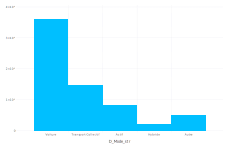

In [8]:
set_default_plot_size(9inch, 6inch)
plot(train, x=:D_Mode_str, Geom.histogram)

In [56]:
for i=1:5
    println(sqrt(size(train[train[:D_Mode] .== i, :], 1)))
end

189.8473070654414
121.02479084881742
45.8257569495584
91.55326318597278
71.45628033979938


> <font color="blue"> On remarque que la voiture est le mode de transport le plus populaire.

### Fréquence des modes de transport en fonction de la distance du ménage au centre ville

Affiche le nombre de déplacements par modes en fonction de la distance du domicile à la gare centrale de Montréal.

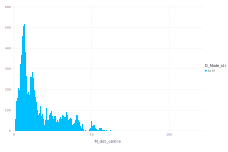

In [64]:
plot(train[train[:D_Mode] .== 4, :], x=:M_dist_centre, color=:D_Mode_str,
     Geom.histogram(bincount=92), Coord.cartesian(xmin=0, xmax = 121))

> <font color="blue"> On remarque que quand la distance du domicile à la gare centrale de Montréal est petite, les gens ont tendance à utiliser un mode de transport actif ou les transports collectifs. Plus le domicile est loi de la gare centrale, plus l'usage de l'automobile devient important.
    
> <font color="blue"> On remarque aussi que la plupart des gens questionnés avaient un domicile proche de la Gare de la gare centrale de Montréal. Ceci peut refléter la réalité où la densité de la population est plus importante au centre-ville que dans les banlieues.

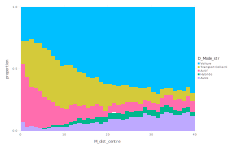

In [10]:
df = histnorm(train,0:1:40,:M_dist_centre)
plot(df, x = :M_dist_centre, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

### Fréquence des modes de transport en fonction de l'âge des individus

Affiche le nombre de déplacements par modes en fonction de l'âge des individus.

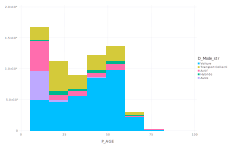

In [11]:
plot(train, x=:P_AGE, color=:D_Mode_str, Geom.histogram(bincount=8))

> <font color="blue"> On remarque que les gens de moins de 25 ans ont plus tendance à prendre d'autres modes de transport que la voiture.

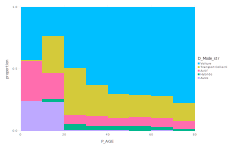

In [12]:
df = histnorm(train,0:10:80,:P_AGE)
plot(df, x = :P_AGE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

### Fréquence des modes de transport en fonction de la distance au métro le plus proche

La distance est en km.

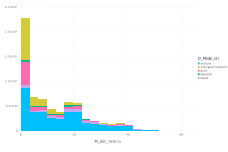

In [13]:
plot(train, x=:M_dist_metro, color=:D_Mode_str,
     Geom.histogram(bincount=20), Coord.cartesian(xmin=0, xmax = 65))

> <font color="blue"> L'utilisation des transports collectifs et des modes actifs sont prépondérant lorsque la distance entre le domicile et la station de métro la plus proche est à moins de ~2 km. L'automobile est plus prisée au fur et à mesure que la distance augmente. 
    

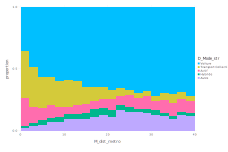

In [14]:
df = histnorm(train,0:2:40,:M_dist_metro)
plot(df, x = :M_dist_metro, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

### Fréquence des modes de transport en fonction du nombre d'emplois disponibles à moins de 45 min de transport en commun

Trajet calculé à 8h00 du matin.

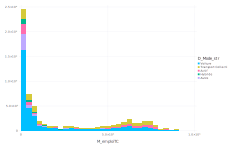

In [15]:
plot(train, x=:M_emploiTC, color=:D_Mode_str, Geom.histogram(bincount=30))

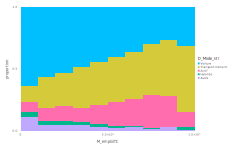

In [16]:
df = histnorm(train,0:1e5:1e6,:M_emploiTC)
plot(df, x = :M_emploiTC, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

### Fréquence des modes de transports en fonction du statut de la personne

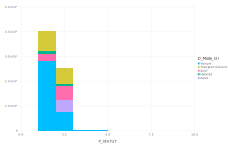

In [17]:
plot(train, x=:P_STATUT, color=:D_Mode_str, Geom.histogram(bincount=8))

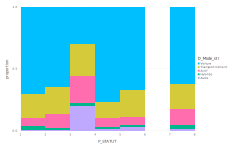

In [18]:
df = histnorm(train,0:1:8,:P_STATUT)
plot(df, x = :P_STATUT, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmin=1))

### Fréquence des modes de transport en fonction de la possession d'un permis de conduire

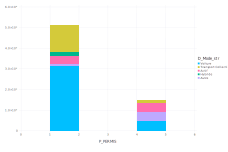

In [19]:
plot(train, x=:P_PERMIS, color=:D_Mode_str, Geom.histogram)

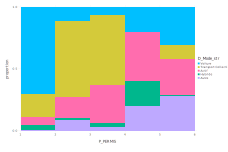

In [20]:
df = histnorm(train,0:1:8,:P_PERMIS)
plot(df, x = :P_PERMIS, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmin=1, xmax=6))

### Fréquence des modes de transport en fonction du groupe d'age des personnes

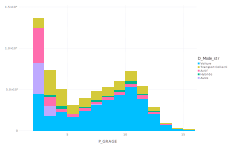

In [21]:
plot(train, x=:P_GRAGE, color=:D_Mode_str, Geom.histogram, Coord.cartesian(xmin=1, xmax=16))

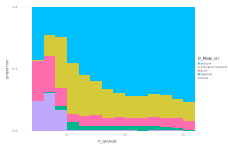

In [22]:
df = histnorm(train,1:1:16,:P_GRAGE)
plot(df, x = :P_GRAGE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmin=1, xmax=16))

### Fréquence des modes de transport en fonction de l'heure de départ

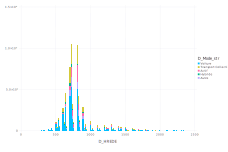

In [42]:
train[:D_HREDE] .%= 2400; 
plot(train, x=:D_HREDE, color=:D_Mode_str, Geom.histogram)

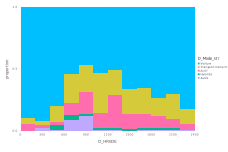

In [45]:
df = histnorm(train,0:200:2400,:D_HREDE)
plot(df, x = :D_HREDE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmax=2400))

## Génération d'un fichier de prédiction pour Kaggle

In [16]:
d = min.(data[:M_dist_metro],data[:M_dist_metro])
data[:M_dist_TC] = d;

UndefVarError: UndefVarError: data not defined

In [ ]:
ind = data[:M_dist_TC] .< 3
df = data[ind,:]
plot(df, x=:D_Mode, Geom.histogram)

In [ ]:
ind = data[:M_dist_centre] .< 1
df = data[ind,:]
plot(df, x=:D_Mode, Geom.histogram)

In [ ]:
ind = data[:D_Mode] .== "TC"
Mode2 = data[ind,:]

In [ ]:
n = size(Mode2,1)
nbin = round(sqrt(n))

fd = fit(Gamma,Mode2[:M_dist_metro])
xx = range(0,stop = 40, length=1000)


h = layer(Mode2,x=:M_dist_metro, Geom.histogram(bincount=nbin, density=true), Theme(default_color="deepskyblue"))
d = layer(x=xx,y=pdf.(fd,xx), Geom.line, Theme(default_color="red"))
plot(d,h, Coord.cartesian(xmin=0, xmax=25))

In [ ]:
n = size(Mode2,1)
nbin = round(sqrt(n))

fd = fit(Weibull,Mode2[:M_dist_metro])
xx = range(0,stop = 40, length=1000)


h = layer(Mode2,x=:M_dist_metro, Geom.histogram(bincount=nbin, density=true), Theme(default_color="deepskyblue"))
d = layer(x=xx,y=pdf.(fd,xx), Geom.line, Theme(default_color="red"))
plot(d,h, Coord.cartesian(xmin=0, xmax=25))